In [92]:
import numpy as np
import pandas as pd
import yfinance as yf
import pyfolio as pf
from hmmlearn import hmm
from sklearn.utils import check_random_state

# For data visualization
import matplotlib.pyplot as plt

# For ignoring warnings
import warnings
warnings.filterwarnings('ignore')

In [93]:
def directional_change_events(data, theta=0.2):

    # Copy the dataframe
    data = data.copy()

    # Create the necessary columns and variables
    data["Event"] = 0.0

    # Set the initial event variable value
    event = "upward" # initial event

    # Set the initial value for low and high prices
    ph = data['Close'].iloc[0] # highest price
    pl = data['Close'].iloc[0] # lowest price

    # Create loop to run through each date
    for t in range(0, len(data.index)):
        # Check if we're on a downward trend
        if event == "downward":
            # Check if the close price is higher than the low price by the theta threshold
            if data["Close"].iloc[t] >= pl * (1 + theta):
                # Set the event variable to upward
                event = "upward"
                # Set the high price as the current close price                
                ph = data["Close"].iloc[t]
            # If the close price is lower than the low price by the theta threshold
            else:
                # Check if the close price is less than the low price
                if data["Close"].iloc[t] < pl:
                    # Set the low price as the current close price
                    pl = data["Close"].iloc[t]
                    # Set the Event to upward for the current period
                    data["Event"].iloc[t] = 1
        # Check if we're on a upward trend
        elif event == "upward":
            # Check if the close price is less than the high price by the theta threshold
            if data["Close"].iloc[t] <= ph * (1 - theta):  
                # Set the event variable to downward
                event = "downward"
                # Set the low price as the current close price
                pl = data["Close"].iloc[t]
            # If the close price is higher than the high price by the theta threshold
            else:
                # Check if the close price is higher than the high price
                if data["Close"].iloc[t] > ph:
                    # Set the high price as the current close price
                    ph = data["Close"].iloc[t]
                    # Set the Event to downward for the current period
                    data["Event"].iloc[t] = -1

    # Set the peak and trough prices and forward-fill the column
    data['peak_trough_prices'] = np.where(data['Event']!=0, data['Close'],0)
    data['peak_trough_prices'].replace(to_replace=0, method='ffill', inplace=True)

    # Count the number of periods between a peak and a trough
    data['count'] = 0
    for i in range(1,len(data.index)):
        if data['Event'].iloc[(i-1)]!=0:
            data['count'].iloc[i] = 1+data['count'].iloc[(i-1)]
        else:
            data['count'].iloc[i] = 1

    # Compute the TMV indicator
    data['TMV'] = np.where(data['Event']!=0, abs(data['peak_trough_prices']-data['peak_trough_prices'].shift())/\
                          (data['peak_trough_prices'].shift()*theta),0)

    # Compute the time-completion-for-a-trend indicator
    data['T'] = np.where(data['Event']!=0, data['count'],0)

    # Compute the time-adjusted-return indicator and forward-fill it
    data['R'] = np.where(data['Event']!=0, np.log(data['TMV']/data['T']*theta),0)
    data['R'] = data['R'].replace(to_replace=0, method='ffill')

    # Drop NaN or inifinite values
    data.replace([np.inf, -np.inf], np.nan, inplace=True)

    return data

In [94]:
# Download the GBPUSD data from 2003 to 2013
data = pd.read_csv("spx500.csv")

# Compute the log returns
data['returns'] = np.log(data['Close']/data['Close'].shift(1))

# Print the data
data

,Date,Close,Open,High,Low,returns
0,02/25/2025,5955.25,5982.73,5992.65,5908.49,NaN
1,02/24/2025,5983.25,6026.69,6043.65,5977.83,0.004691
2,02/21/2025,6013.13,6114.10,6114.82,6008.56,0.004982
3,02/20/2025,6117.52,6134.50,6134.50,6084.59,0.017211
4,02/19/2025,6144.15,6117.76,6147.43,6111.15,0.004344
...,...,...,...,...,...,...
2515,03-05-2015,2101.04,2098.54,2104.25,2095.22,0.014275
2516,03-04-2015,2098.53,2107.72,2107.72,2087.62,-0.001195
2517,03-03-2015,2107.78,2115.76,2115.76,2098.26,0.004398
2518,03-02-2015,2117.39,2105.23,2117.52,2104.50,0.004549


In [95]:
data = directional_change_events(data, theta=0.004)

# Change the index type to datetime
data.index = pd.to_datetime(data.index)

# Drop NaN values
data.dropna(inplace=True)

# Present the data
data

,Date,Close,Open,High,Low,returns,Event,peak_trough_prices,count,TMV,T,R
1970-01-01 00:00:00.000000002,02/21/2025,6013.13,6114.10,6114.82,6008.56,0.004982,-1.0,6013.13,2,1.248485,2,-5.992677
1970-01-01 00:00:00.000000003,02/20/2025,6117.52,6134.50,6134.50,6084.59,0.017211,-1.0,6117.52,3,4.340086,3,-5.152179
1970-01-01 00:00:00.000000004,02/19/2025,6144.15,6117.76,6147.43,6111.15,0.004344,-1.0,6144.15,4,1.088268,4,-6.823168
1970-01-01 00:00:00.000000005,02/18/2025,6129.58,6121.60,6129.63,6099.51,-0.002374,0.0,6144.15,5,0.000000,0,-6.823168
1970-01-01 00:00:00.000000006,02/14/2025,6114.63,6115.52,6127.47,6107.62,-0.002442,0.0,6144.15,1,0.000000,0,-6.823168
...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-01 00:00:00.000002515,03-05-2015,2101.04,2098.54,2104.25,2095.22,0.014275,-1.0,2101.04,1,5.800136,1,-3.763579
1970-01-01 00:00:00.000002516,03-04-2015,2098.53,2107.72,2107.72,2087.62,-0.001195,0.0,2101.04,2,0.000000,0,-3.763579
1970-01-01 00:00:00.000002517,03-03-2015,2107.78,2115.76,2115.76,2098.26,0.004398,-1.0,2107.78,1,0.801984,1,-5.742128
1970-01-01 00:00:00.000002518,03-02-2015,2117.39,2105.23,2117.52,2104.50,0.004549,-1.0,2117.39,2,1.139825,2,-6.083733


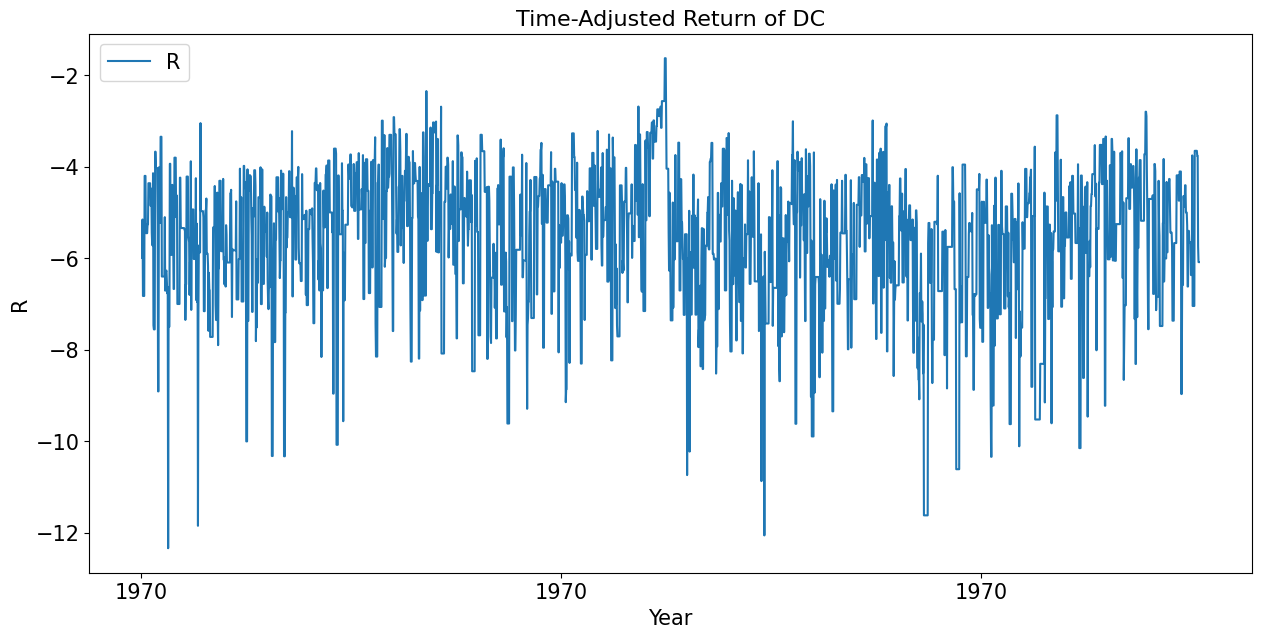

In [96]:
# Set the figure size
plt.figure(figsize=(15,7))

# Plot the R indicator
plt.plot(data.index, data['R'], label = "R")

# Set the title of the graph
plt.title('Time-Adjusted Return of DC', fontsize=16)

# Set the x- and y- axis labels and ticks sizes
plt.xlabel('Year', fontsize=15)
plt.ylabel('R', fontsize=15)
plt.tick_params(axis='both', labelsize=15)

# Set the plot legend location
plt.legend(loc=2, prop={'size': 15}, bbox_to_anchor=(0,1))

plt.show()

In [97]:
# Count number of downward and upward events
data['Event'].value_counts()

Event
 0.0    1359
 1.0     709
-1.0     450
Name: count, dtype: int64

In [98]:
# Create an HMM object with two hidden states
model = hmm.GaussianHMM(n_components = 2, covariance_type = "diag", n_iter = 100, random_state = 42)

# Create an array input for the HMM model
X = data[['R']].values

# Estimate the HMM model
results = model.fit(X)

# Use the Viterbi algorithm to find the fitted hidden states
data['states'] = results.predict(X)

# Count the number of days in which we find the two states
data['states'].value_counts()

states
0    1519
1     999
Name: count, dtype: int64

In [99]:
# Find the R mean for state 0
state0_R_vol = data['R'][data['states']==0].mean()

# Find the R mean for state 1
state1_R_vol = data['R'][data['states']==1].mean()

# Print the R volatility for both states
print(f'Volatility for state 0, 1 and 2 are {state0_R_vol:.2f} and {state1_R_vol:.2f}, respectively')

Volatility for state 0, 1 and 2 are -4.70 and -7.10, respectively


In [100]:
# Find the returns standard deviation for state 0
state0_vol = data['returns'][data['states']==0].std()*np.sqrt(252)*100

# Find the returns standard deviation for state 1
state1_vol = data['returns'][data['states']==1].std()*np.sqrt(252)*100

# Print the returns volatility for both states
print(f'Volatility for state 0 and 1 are {state0_vol:.2f} and {state1_vol:.2f}, respectively')

Volatility for state 0 and 1 are 21.17 and 11.05, respectively


In [101]:
type(data.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [102]:
# Create a simple 4-day moving average
data['sma'] = data['Close'].rolling(3).mean()

# Create the strategy signal
data['signal'] = np.where(data['Close']>data['sma'],1.0,-1.0)

# Create the leverage column
data['dc_leverage'] = 0.0

# Create the next state column
data['dc_next_state'] = 0.0

In [103]:
data

,Date,Close,Open,High,Low,returns,Event,peak_trough_prices,count,TMV,T,R,states,sma,signal,dc_leverage,dc_next_state
1970-01-01 00:00:00.000000002,02/21/2025,6013.13,6114.10,6114.82,6008.56,0.004982,-1.0,6013.13,2,1.248485,2,-5.992677,1,NaN,-1.0,0.0,0.0
1970-01-01 00:00:00.000000003,02/20/2025,6117.52,6134.50,6134.50,6084.59,0.017211,-1.0,6117.52,3,4.340086,3,-5.152179,1,NaN,-1.0,0.0,0.0
1970-01-01 00:00:00.000000004,02/19/2025,6144.15,6117.76,6147.43,6111.15,0.004344,-1.0,6144.15,4,1.088268,4,-6.823168,1,6091.600000,1.0,0.0,0.0
1970-01-01 00:00:00.000000005,02/18/2025,6129.58,6121.60,6129.63,6099.51,-0.002374,0.0,6144.15,5,0.000000,0,-6.823168,1,6130.416667,-1.0,0.0,0.0
1970-01-01 00:00:00.000000006,02/14/2025,6114.63,6115.52,6127.47,6107.62,-0.002442,0.0,6144.15,1,0.000000,0,-6.823168,1,6129.453333,-1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-01 00:00:00.000002515,03-05-2015,2101.04,2098.54,2104.25,2095.22,0.014275,-1.0,2101.04,1,5.800136,1,-3.763579,0,2083.910000,1.0,0.0,0.0
1970-01-01 00:00:00.000002516,03-04-2015,2098.53,2107.72,2107.72,2087.62,-0.001195,0.0,2101.04,2,0.000000,0,-3.763579,0,2090.276667,1.0,0.0,0.0
1970-01-01 00:00:00.000002517,03-03-2015,2107.78,2115.76,2115.76,2098.26,0.004398,-1.0,2107.78,1,0.801984,1,-5.742128,0,2102.450000,1.0,0.0,0.0
1970-01-01 00:00:00.000002518,03-02-2015,2117.39,2105.23,2117.52,2104.50,0.004549,-1.0,2117.39,2,1.139825,2,-6.083733,0,2107.900000,1.0,0.0,0.0


In [ ]:
import yfinance as yf

In [ ]:
yf.download("^NSEI", start = "2025-01-01", "2025-02-2025")

In [104]:
# Create the backtesting loop
for t in range(0, (len(data.index)-1)):
    # Create a data sample to be used for the trading computations
    data_sample = data[['R','returns']].iloc[:(t+1)]

    # Create an HMM model object
    dc_model = hmm.GaussianHMM(n_components = 2, covariance_type = "diag", n_iter = 200, random_state = 100)

    # Create the array input to be used for the HMM model
    dc_X = data_sample[['R']].values

    # Fit the model to the data
    dc_results = dc_model.fit(dc_X)
    
    # Obtain the fitted hidden states for the data sample
    data_sample['dc_states'] = dc_results.predict(dc_X)

    # Compute the next state hidden state
    dc_transmat_cdf = np.cumsum(dc_results.transmat_, axis=1)
    dc_random_state = check_random_state(dc_results.random_state)
    data['dc_next_state'].iloc[t] = (dc_transmat_cdf[data_sample['dc_states'].iloc[-1]] > dc_random_state.rand()).argmax()
    
    # Compute the R volatility for each state
    dc_state0_vol = data_sample['R'][data_sample['dc_states']==0].mean()
    dc_state1_vol = data_sample['R'][data_sample['dc_states']==1].mean()

    # Invest all capital if the forecasted regime is 0 and its volatility is higher than regime 1
    if (data['dc_next_state'].iloc[t]==0) and (dc_state0_vol>dc_state1_vol):
        data['dc_leverage'].iloc[t] = 1.0
    # Invest 2 times the capital if the forecasted regime is 0 and its volatility is lower than regime 1
    elif (data['dc_next_state'].iloc[t]==0) and (dc_state0_vol<dc_state1_vol):
        data['dc_leverage'].iloc[t] = 2.0
    # Invest 2 times the capital if the forecasted regime is 1 and its volatility is lower than regime 1
    elif (data['dc_next_state'].iloc[t]==1) and (dc_state0_vol>dc_state1_vol):
        data['dc_leverage'].iloc[t] = 2.0
    # Invest all capital if the forecasted regime is 1 and its volatility is higher than regime 1
    else:
        data['dc_leverage'].iloc[t] = 1.0

# Set the final signal to 0 to square off any open position
data['signal'].iloc[-1] = 0.0

Fitting a model with 7 free scalar parameters with only 1 data points will result in a degenerate solution.


ValueError: n_samples=1 should be >= n_clusters=2.

In [ ]:
data.index = pd.to_datetime(data.index)
plot_data = data.loc['1999-11-01':]

# Count the number of days in which we face different leverages
plot_data['dc_leverage'].value_counts()

Series([], Name: count, dtype: int64)

In [ ]:

# Compute the Buy-and-Hold cumulative returns
plot_data['buy_hold_cum_rets'] = np.exp(plot_data['returns'].cumsum())

# Compute the simple 4-day moving average strategy returns
plot_data['basic_stra_rets'] = plot_data['returns']*plot_data['signal'].shift(1)

# Compute the simple 4-day moving average strategy cumulative returns
plot_data['basic_stra_cum_rets'] = np.exp(plot_data['basic_stra_rets'].cumsum())

# Compute the HMM-DC-based strategy returns
plot_data['hmm_dc_stra_rets'] = plot_data['returns']*plot_data['signal'].shift(1)*plot_data['dc_leverage'].shift(1)

# Compute the HMM-DC-based strategy cumulative returns
plot_data['hmm_dc_stra_cum_rets'] = np.exp(plot_data['hmm_dc_stra_rets'].cumsum())

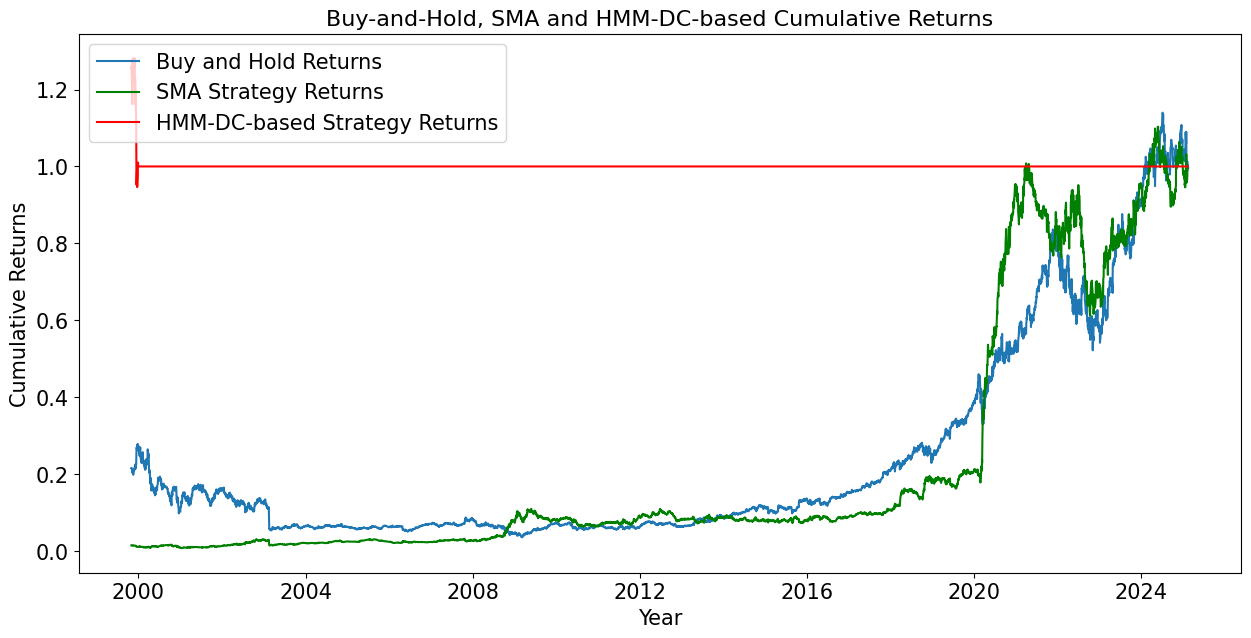

In [ ]:
# Set the figure size
plt.figure(figsize=(15,7))

# Plot both the Buy-and-hold, SMA and HMM-DC-based strategy cumulative returns
plt.plot(plot_data.index, plot_data['buy_hold_cum_rets'], label = "Buy and Hold Returns")
plt.plot(plot_data.index, plot_data['basic_stra_cum_rets'], label = "SMA Strategy Returns", color='g')
plt.plot(plot_data.index, plot_data['hmm_dc_stra_cum_rets'], label = "HMM-DC-based Strategy Returns", color='r')

# Set the title of the graph
plt.title('Buy-and-Hold, SMA and HMM-DC-based Cumulative Returns', fontsize=16)

# Set the x- and y- axis labels and ticks sizes
plt.xlabel('Year', fontsize=15)
plt.ylabel('Cumulative Returns', fontsize=15)
plt.tick_params(axis='both', labelsize=15)

# Set the plot legend location
plt.legend(loc=2, prop={'size': 15}, bbox_to_anchor=(0,1))

plt.show()